# MPD Processing Notebook Summary

This Python notebook processes Mobile Positioning Data (MPD) to infer the anchoring location of each subscriber. 

The inferred results are used to measure the proxy indicator for `SDGs Indicator 17.8.1, which is the proportion of individuals using the Internet`.

The processing steps are as follows:

1. **Initiate spark connection to access MPD filtered data:**

    This step initiates a spark connection to access `MPD filtered data`. MPD is a dataset that contains information about the location of mobile devices at different times and can be used to analyze subscriber behavior and infer their home locations.

2. **Data Summarization:** 

    The data is summarized into two sets of summary data: `User Summary` and `Cell Summary`. User Summary calculates user activity statistics such as the number of events/records, unique cell locations, unique days, principal technology used, and highest technology used. Each of these indicators is aggregated by different types of data sources, either from CDR or IPDR. On the other hand, Cell Summary categorizes the MPD into four distinct time periods called anchors: `early morning`, `morning`, `office hour`, and `night`. This categorization allows a better understanding and analysis of subscriber behavior based on different times of the day.

3. **Anchoring: Infer Home Candidate Location:** 

    The primary objective of this step is to infer the most probable cell tower associated with a `subscriber's home location`. This inference process relies on the data from the early morning class since it provides the highest likelihood of capturing the home location. However, if a direct inference cannot be made solely based on the early morning class, the system takes into account data from other time periods to enhance the accuracy of the inference.

4. **Evaluation**:

    The Evaluation section is crucial for assessing the accuracy of home location inference. Metrics like `anchor label distribution` and `anchor cell ID distribution` help identify typical mobility patterns and spatial distribution of potential home locations. This data can be used to refine and optimize the inference process.


# 1. Initiate spark connection

This step initiates a spark connection to access `MPD filtered data`. MPD is a dataset that contains information about the location of mobile devices at different times and can be used to analyze subscriber behavior and infer their home locations. 

Spark is a distributed computing system that can handle large datasets and perform parallel processing. By initiating a Spark connection, the notebook can efficiently process the MPD data. The notebook uses PySpark, which is the Python API for Spark, to interact with the Spark cluster.

The MPD data used in this notebook has already been filtered based on certain criteria in the previous step. This filtering ensures that the data is of high quality and relevant to the analysis being performed. Once the Spark connection is established, the notebook can proceed to the next step of summarizing the data.


In [ ]:
# Import the sys module to adjust the Python system path
import sys

# Append a path to the system path so that Python can import modules from the specified directory (relative path)
sys.path.append('../')

# Import the CONF, QA_summary and QA_action_plan variables from the script.QA module
from script.conf import *

In [ ]:
# Import the os module to interact with the operating system
import os

# Try to create a new directory at the path QA_PATH using os.mkdir()
# If the directory already exists, print a message stating that it does
try:
    os.mkdir(ANCHOR_PATH)
    print("Create new folder {}".format(ANCHOR_PATH))
except FileExistsError:
    print("Folder {} already exists".format(ANCHOR_PATH))

In [ ]:
# Import Pandas module
import pandas as pd

# Import the PySpark module
import pyspark

import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
from pyspark.sql.window import Window

# Import the SparkSession from PySpark
from pyspark.sql import SparkSession

# Create a SparkSession with the specified configuration
spark = SparkSession.builder\
        .master("local[{}]".format(CORE))\
        .appName("02.ITU.PySpark-Anchoring")\
        .config('spark.sql.execution.arrow.pyspark.enabled', 'true')\
        .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Print the spark object which contains the SparkSession
spark

In [ ]:
# Use this code below to connect your remote spark cluster instead.

# # Import the PySpark module
# import pyspark
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

# import pyspark.sql.functions as f
# from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
# from pyspark.sql.window import Window

# # Import the SparkSession from PySpark
# from pyspark.sql import SparkSession

# CLUSTER_URL = "spark://master"
# PORT = "7077"

# # Create a SparkSession with the specified configuration remote server
# spark = SparkSession.builder\
#         .master("{}:{}".format(CLUSTER_URL,PORT))\
#         .appName("01.ITU.PySpark-Raw")\
#         .getOrCreate()

# # Print the spark object which contains the SparkSession
# spark

In [ ]:
# This code reads a parquet file located in "../data/" with name "MPD_sample_synthetic_filtered".
# It uses Apache Spark to load the data and creates a dataframe object named df.
# The first 5 rows of the dataframe are then printed using df.show(5)
# Finally, the total number of records in the dataframe is printed using df.count()

df = spark.read.format('parquet').load(BASE_PATH+FILTERED_FILE_PATH_PARQUET) # Load parquet file into a dataframe named df

df.show(5) # Show the first 5 records of the dataframe

print("Number of records: {}".format(df.count())) # Print the total number of records in the dataframe

# 2. Data Summarization

After loading the filtered MPD data into a Spark DataFrame, the next step is to summarize the data by subscriber ID. This involves grouping the data by subscriber ID and calculating various summary statistics, such as the total number of records per subscriber, the minimum and maximum timestamps, and the total duration of each subscriber's activity.

To perform this task, we can use Spark's DataFrame API, which provides powerful aggregation functions for summarizing data. We start by grouping the data by the `subscriber_id` column using the `groupBy()` method. We can then apply various aggregation functions to the grouped data using the `agg()` method.

For example, to calculate the total number of records per subscriber, we can use the `count()` aggregation function. To calculate the minimum and maximum timestamps, we can use the `min()` and `max()` functions, respectively. Finally, to calculate the total duration of each subscriber's activity, we can subtract the minimum timestamp from the maximum timestamp and convert the result to seconds.

Once we have calculated these summary statistics, we can use them to gain insights into subscriber behavior and identify potential anomalies or outliers. For example, subscribers with a very high number of records or a very long duration of activity may be exhibiting unusual behavior that warrants further investigation.

## a. User Summary

The goal of the code is to create a new DataFrame called `user_stats` that summarizes activity for each unique subscriber ID in the dataset.

Firstly, creates a new column called `service_numeric` that maps the values in the `service` column to numeric values (1 for "2G", 2 for "3G", 3 for "4G", and 0 for all other values). This allows the code to later calculate the highest service used by each user based on the numeric mapping.

Next, the code groups the `user_stats` DataFrame by "msisdn" (subscriber ID) and applies various aggregations to calculate user statistics. These include counting the number of CDR and IPDR events for each user, counting the number of distinct cells and dates for each event type, and finding the main service used by each user based on the mode of the service values in the CDR and IPDR events.

Finally, the code adds two new columns to the `user_stats` DataFrame: `internet_user`, which is a boolean value indicating whether the user has any IPDR events (i.e., internet usage), and `highest_service`, which is a string value indicating the highest service used by each user (based on the `service_numeric` mapping).

Overall, the user summary code provides a comprehensive summary of activity for each unique subscriber ID in the dataset, including information on the types of events recorded, the number of distinct cells and dates involved, and the highest service used by each user.

In [ ]:
# Import necessary functions from the PySpark library
from pyspark.sql.functions import count, countDistinct, when, col, mode, dayofmonth, max

# Define a new DataFrame called `user_stats` by applying transformations on an existing DataFrame called `df`
user_stats = df\
    .withColumn('service_numeric',
        when(col('service')=='2G',1)\
        .when(col('service')=='3G',2)\
        .when(col('service')=='4G',3)\
        .otherwise(0)) # For all other values in the "service" column, set service_numeric to the value 0
    
# Group the `user_stats` DataFrame by "msisdn" and apply various aggregations to calculate user statistics
user_stats = user_stats.groupBy('msisdn')\
    .agg(
        count(when(col('data_type')=='CDR',col('datetime'))).alias('CDR_events'), # Count the number of CDR events for each user
        count(when(col('data_type')=='IPDR',col('datetime'))).alias('IPDR_events'), # Count the number of IPDR events for each user
        countDistinct(when(col('data_type')=='CDR',col('cell_id'))).alias('CDR_cell'), # Count the number of distinct cells for CDR events for each user
        countDistinct(when(col('data_type')=='IPDR',col('cell_id'))).alias('IPDR_cell'), # Count the number of distinct cells for IPDR events for each user
        countDistinct(when(col('data_type')=='CDR',col('date'))).alias('CDR_date'), # Count the number of distinct dates for CDR events for each user
        countDistinct(when(col('data_type')=='IPDR',col('date'))).alias('IPDR_date'), # Count the number of distinct dates for IPDR events for each user
        mode(when(col('data_type')=='CDR',col('service'))).alias('CDR_main_service'), # Find the main service from CDR events
        mode(when(col('data_type')=='IPDR',col('service'))).alias('IPDR_main_service'), # Find the main service from IPDR events
        max(when(col('data_type')=='IPDR',col('service_numeric'))).alias('IPDR_highest_service')
    )\
    .withColumn('internet_user', when(col('IPDR_events')>0, True).otherwise(False))\
    .withColumn('IPDR_highest_service',when(col('IPDR_highest_service')==3, "4G")\
        .when(col('IPDR_highest_service')==2,"3G")\
        .when(col('IPDR_highest_service')==1,"2G").otherwise("UNKNOWN"))\
    .select('msisdn','internet_user','IPDR_events','CDR_events','IPDR_cell','CDR_cell','IPDR_date','CDR_date','CDR_main_service','IPDR_main_service','IPDR_highest_service')

user_stats.cache()

# Show the first five rows of the `user_stats` DataFrame
user_stats.show(5)


In [ ]:
# Coalesce the dataframe 'user_stats' into a single partition
coalesced_df = user_stats.coalesce(1)

# Write the coalesced dataframe to a CSV file with specified options and overwrite any existing file
coalesced_df.write.option("header", True).option("sep", "\t").mode("overwrite").csv(ANCHOR_PATH+"summary1_user_stats")

In [ ]:
# Convert the PySpark DataFrame `user_stats` to a Pandas DataFrame, then sort the resulting DataFrame by "msisdn"
user_stats_pd = user_stats.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"summary1_user_stats.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
user_stats_pd.to_csv(targeted_path_csv, index=False, sep="\t")

## b. Cell Summary


The goal of this code is to summarize activity for each unique combination of subscriber ID, date, anchor type, and cell ID in the dataset. To achieve this, the code first creates a new column called `anchor_type` that maps the hour of the `datetime` column to four different anchor types ("ANCHOR_1", "ANCHOR_2", "ANCHOR_3", and "OUTTIME") based on a set of conditions.

This code creates a new data frame called "cell_stats" from an existing data frame named "df". 

It does this by adding two new columns named "hour" and "anchor_type". The "hour" column is created using the `hour()` function which extracts the hour from the "datetime" column. The "anchor_type" column is created using the `when()` function along with logical operators. 

It defines four anchor time categories - `"Early Morning"`, `"Morning"`, `"Office Hours"` and `"Night"`. 

Default settings:
- anchor_1 :  0 -  5 -> "Early Morning"
- anchor_2 :  5 -  8 -> "Morning"
- anchor_3 : 21 -  0 -> "Night"
- outtime  :  8 - 21 -> "Office Hours"

Each of these categories corresponds to a specific range of hours in the day. The code assigns each row a category by matching the hour value in the "hour" column against the defined ranges, and then populating the corresponding anchor type in the "anchor_type" column. Finally it returns the new data frame "cell_stats" including the original columns from "df" along with the newly added columns "hour" and "anchor_type".

In [ ]:
# Import necessary functions from pyspark.sql.functions module
from pyspark.sql.functions import when, hour, count, col, dayofweek, max, date_format

# Create a new DataFrame 'cell_stats' by adding two columns 'hour' and 'anchor_type' to the input DataFrame 'df'
cell_stats = df \
    .withColumn('hour', hour('datetime')) \
    .withColumn('anchor_type', 
        when((col('hour') >= ANCHOR_CONF['ANCHOR_1'][0]) & ((col('hour') < ANCHOR_CONF['ANCHOR_1'][1])), "ANCHOR_1") \
        .when((col('hour') >= ANCHOR_CONF['ANCHOR_2'][0]) & ((col('hour') < ANCHOR_CONF['ANCHOR_2'][1])), "ANCHOR_2") \
        .when((col('hour') >= ANCHOR_CONF['ANCHOR_3'][0]) & ((col('hour') < ANCHOR_CONF['ANCHOR_3'][1])), "ANCHOR_3") \
        .otherwise("OUTTIME")
    )


The code then creates a new DataFrame called `cell_stats2` that includes the `max_cnt` (maximum event count) for each unique combination of `msisdn`, `date`, and `anchor_type` using a window function.

The code also adds two new columns to the `cell_stats2` DataFrame: `day_of_week`, which indicates the day of the week for each date value, and `is_weekday`, which is a boolean value indicating whether the day of the week is a weekday (i.e., not a weekend).

The code then filters the `cell_stats2` DataFrame to include only rows where `cnt` is equal to `max_cnt`, and where `is_weekday` is True. The resulting DataFrame is then further processed to include only the desired columns (`msisdn`, `date`, `is_weekday`, `anchor_type`, `cell_id`, and `cnt`) and is sorted by `msisdn`, `date`, `anchor_type`, and `cnt` in descending order.

In [ ]:
# Create a new DataFrame 'cell_stats2' by grouping the rows of 'cell_stats' by 'msisdn', 'date', 'anchor_type', and 'cell_id'
# Count the number of rows in each group and rename the resulting column to 'cnt'
cell_stats2 = cell_stats \
    .groupBy('msisdn', 'date', 'anchor_type', 'cell_id') \
    .agg(count(col('datetime')).alias('cnt'))

# Define a window specification 'grp' with three partition columns: 'msisdn', 'date', 'anchor_type'
# This is used later to compute the maximum count for each group (partition) separately
grp = Window.partitionBy('msisdn', 'date', 'anchor_type')

# Create a new DataFrame 'cell_stats3' by adding three new columns ('max_cnt', 'day_of_week', 'is_weekday') and filtering rows
# Compute the maximum count 'max_cnt' within each partition defined by 'grp'
# Extract the day of the week from the 'date' column and store it as 'day_of_week'
# Determine whether the day of the week is a weekday or not and store it as 'is_weekday'
# Filter rows where 'cnt' is equal to the maximum count 'max_cnt'
# Select only the specified columns ('msisdn', 'date', 'is_weekday', 'anchor_type', 'cell_id', 'cnt')

# .withColumn('is_weekday', when((col('day_of_week') > 1) & (col('day_of_week') < 7), True).otherwise(False)) \
    
cell_stats3 = cell_stats2 \
    .withColumn('max_cnt', max('cnt').over(grp)) \
    .withColumn('day_of_week', dayofweek(col('date'))) \
    .withColumn('dayname', date_format(col('date'),'EEEE')) \
    .withColumn('is_weekday', when(col('dayname').isin(ANCHOR_CONF['weekday']), True).otherwise(False)) \
    .filter(col('cnt') == col('max_cnt')) \
    .filter(col('is_weekday'))\
    .select('msisdn', 'date', 'is_weekday', 'anchor_type', 'cell_id', 'cnt')\
    .orderBy('msisdn','date', 'anchor_type', col('cnt').desc())

# Display the resulting DataFrame 'cell_stats3'
cell_stats3.show()


In [ ]:
# Coalesce the dataframe 'user_stats' into a single partition
coalesced_df = cell_stats3.coalesce(1)

# Write the coalesced dataframe to a CSV file with specified options and overwrite any existing file
coalesced_df.write.option("header", True).option("sep", "\t").mode("overwrite").csv(ANCHOR_PATH+"summary2_cell_stats")

In [ ]:
# Convert the Spark DataFrame 'cell_stats3' to a Pandas DataFrame 'cell_stats_pd'
# Sort the rows of 'cell_stats_pd' first by 'msisdn' and then by 'date'
cell_stats_pd = cell_stats3.toPandas().sort_values(['msisdn', 'date'])

# Define the path where the resulting CSV file should be stored
# Use the constant string 'ANCHOR_PATH' as the prefix for the filename
# Append the suffix '_summary2_cell_stats.csv' to the filename
targeted_path_csv = ANCHOR_PATH + "summary2_cell_stats.csv"

# Write the contents of 'cell_stats_pd' to a CSV file at the specified path
# Use '\t' as the field delimiter in the CSV file
# Do not include row numbers in the CSV file
cell_stats_pd.to_csv(targeted_path_csv, index=False, sep="\t")

Finally, the code creates another new DataFrame called `df_anchor` that groups the `cell_stats3` DataFrame by `msisdn`, `is_weekday`, `anchor_type`, and `cell_id`, and applies an aggregation to count the number of days (`day_cnt`) where each unique combination of these columns has the highest event count. This DataFrame is also sorted by `msisdn`, `anchor_type`, and `day_cnt` in descending order.

In [ ]:
# Define a window specification 'window_msisdn_anchor' with partition columns 'msisdn' and 'anchor_type', and order by 'day_cnt' in descending order.
window_msisdn_anchor = Window.partitionBy('msisdn', 'anchor_type').orderBy(col('day_cnt').desc())

# Filter data frame 'cell_stats3' on column 'is_weekday' if the value is True.
# Group the resulting data frame by columns 'msisdn', 'is_weekday', 'anchor_type', and 'cell_id'.
# Aggregate the resulting data frame using count('cnt') function and alias `day_cnt`.
# Order the resulting data frame based on columns 'msisdn', 'anchor_type' and 'day_cnt' in descending order.
df_anchor = cell_stats3 \
    .filter(col('is_weekday') == True) \
    .groupBy('msisdn', 'is_weekday', 'anchor_type', 'cell_id') \
    .agg(
        count('cnt').alias('day_cnt')
    ) \
    .orderBy('msisdn', 'anchor_type', col('day_cnt').desc())

# Cache the resulting data frame to memory.
df_anchor.cache()

# Display the first five rows of the resulting data frame 'df_anchor'.
df_anchor.show(5)


# 3. Anchoring: Infer Home Candidate Location

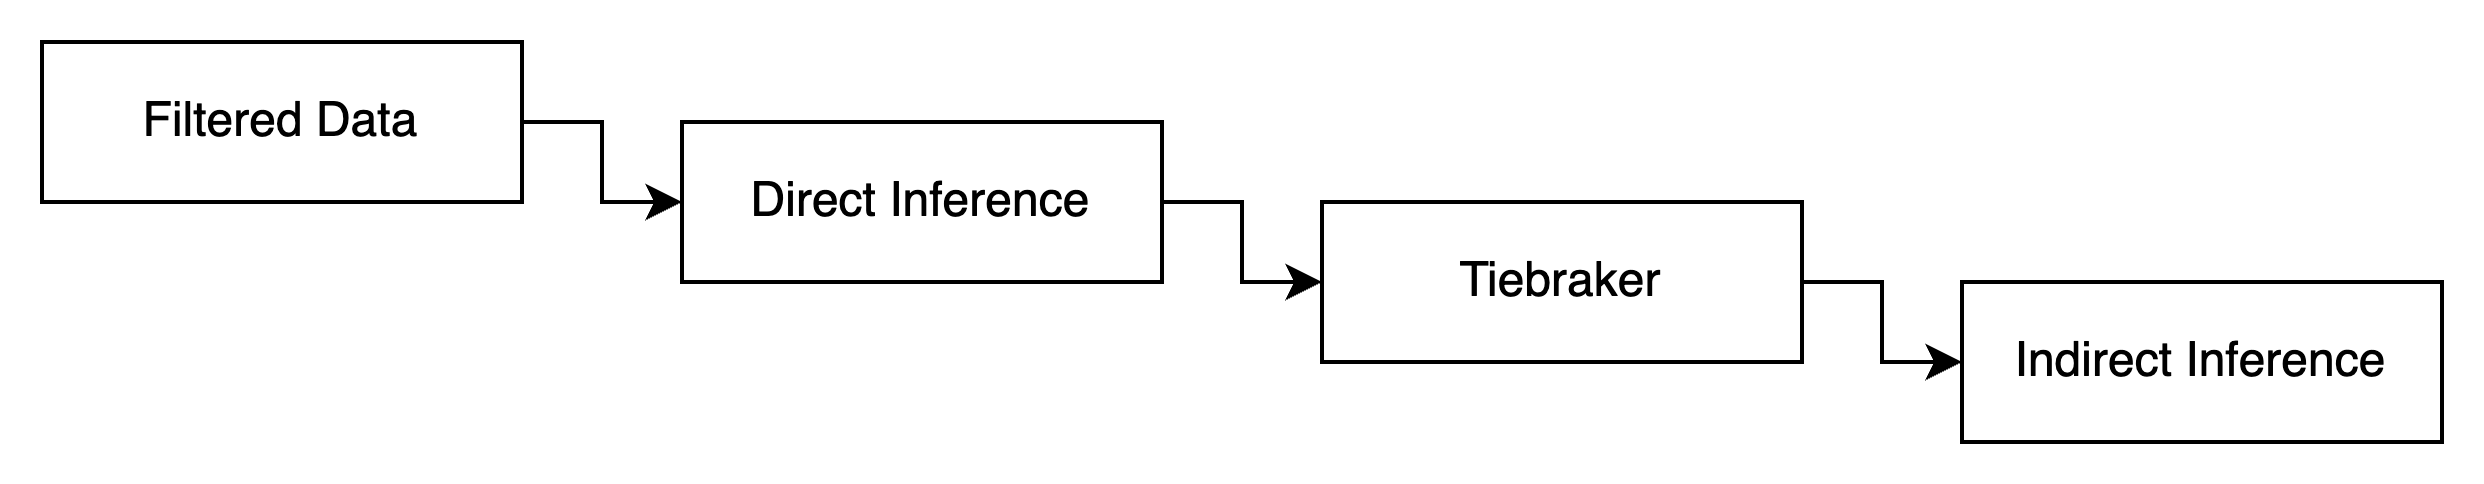

The overall step for inferring the home location of subscribers involves three stages: 
- direct inference, 
- tiebreaker, and 
- indirect inference. 

In the first stage, the code identifies the most frequently used cell ID (i.e., the direct anchor) for each subscriber based on their historical location data.

In the second stage, the code looks for subscribers who have multiple candidates with equal frequency and selects the candidate with the lowest `anchor_cell_id` value as the tiebreaker. This is done separately for Anchor 1, Anchor 2, and Anchor 3.

In the third stage, the code identifies the most frequently used candidate among the remaining candidates (i.e., the indirect anchor) for each subscriber. This is also done separately for Anchor 1, Anchor 2, and Anchor 3.

By combining the results of these three stages, the code can infer the most likely home location for each subscriber based on their historical location data.

## a. Direct Inference

The code first filters for Anchor 1 candidates, assigns a rank to each candidate based on their frequency within each subscriber (using `dense_rank()`), and selects only the candidates with the highest rank (i.e., the most frequently used candidate) for each subscriber. 

Next, it counts the number of candidates for each subscriber and selects only those with a single candidate (`candidate_count == 1`). For these subscribers, it renames the `cell_id` column to `anchor_cell_id`, creates an `anchor_label` column indicating whether the anchor is direct or not, and selects only the relevant columns (`msisdn`, `anchor_type`, `anchor_cell_id`, and `anchor_label`).

In [ ]:
# Import necessary PySpark functions.
from pyspark.sql.functions import col, when, count, lit, dense_rank

# Filter data frame 'df_anchor' on column 'anchor_type' where the value is 'ANCHOR_1'.
# Add a new column called 'rank' using dense_rank() function with window specification 'window_msisdn_anchor'.
# Filter the resulting data frame where the value of column 'rank' is 1.
anchor1_candidates = df_anchor \
    .filter(col("anchor_type") == "ANCHOR_1")\
    .withColumn('rank', dense_rank().over(window_msisdn_anchor)) \
    .filter(col('rank') == 1)

# Group data frame 'anchor1_candidates' by column "msisdn".
# Aggregate the resulting data frame using count("*") function and alias "candidate_count".
anchor1_count = anchor1_candidates.groupBy("msisdn").agg(count("*").alias("candidate_count"))

# Join data frames 'anchor1_candidates' and 'anchor1_count' on 'msisdn'.
# Filter the resulting data frame where the value of column 'candidate_count' is 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'anchor_label' which is set to "DIRECT" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor1_direct = anchor1_candidates.join(anchor1_count, "msisdn").filter(col("candidate_count") == 1)\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("DIRECT")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

# Cache the resulting data frame to memory.
anchor1_direct.cache()

# Count and display the number of rows in the resulting data frame 'anchor1_direct'.
# Display the data frame 'anchor1_direct'.
print(anchor1_direct.count())
anchor1_direct.show()

In [ ]:
anchor1_direct_pd = anchor1_direct.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor1_direct.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor1_direct_pd.to_csv(targeted_path_csv, index=False, sep="\t")

## b. Tiebreaking Inference

For subscribers with multiple candidates, the code uses tiebreaking logic to select the most frequently used candidate. It first identifies the candidates that tied for the highest frequency by joining the Anchor 1 candidates with the count of candidates per subscriber and selecting only those with more than one candidate (`candidate_count > 1`). It then repeats the process for Anchor 2 and Anchor 3 candidates, using the previous tiebreaker results as input.

Finally, for subscribers with ties that could not be broken by Anchor 2 or Anchor 3 candidates, the code selects the candidate with the lowest `cell_id` value (i.e., the earliest candidate). These candidates are labeled as "UNTIE-anchor2" or "UNTIE-anchor3" depending on which anchor was used for the tiebreaking.

In [ ]:
# Join data frames 'anchor1_candidates' and 'anchor1_count' on 'msisdn'. 
# Filter the resulting data frame where the value of column 'candidate_count' is greater than 1. 
# Select columns 'msisdn' and 'cell_id'.
anchor1_tiebraker = anchor1_candidates.join(anchor1_count, "msisdn").filter(col("candidate_count") > 1).select('msisdn','cell_id')

# Filter data frame 'df_anchor' on column 'anchor_type' where the value is 'ANCHOR_2'.
# Join with the data frame 'anchor1_tiebraker' on columns 'msisdn' and 'cell_id'.
# Add a new column called 'rank' using dense_rank() function with window specification 'window_msisdn_anchor'.
# Filter the resulting data frame where the value of column 'rank' is 1.
anchor1_tiebraker_anchor2 = df_anchor\
    .filter(col('anchor_type')=='ANCHOR_2')\
    .join(anchor1_tiebraker.select('msisdn','cell_id'),['msisdn','cell_id'],'inner')\
    .withColumn('rank', dense_rank().over(window_msisdn_anchor))\
    .filter(col('rank')==1)

# Group data frame 'anchor1_tiebraker_anchor2' by column 'msisdn'.
# Aggregate the resulting data frame using count("*") function and alias "candidate_count".
anchor1_tiebraker_anchor2_count = anchor1_tiebraker_anchor2.groupBy("msisdn").agg(count("*").alias("candidate_count"))

# Join data frames 'anchor1_tiebraker_anchor2_count' and 'anchor1_tiebraker_anchor2' on 'msisdn'.
# Filter the resulting data frame where the value of column 'candidate_count' is 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'anchor_label' which is set to "UNTIE-anchor2" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor1_untie2 = anchor1_tiebraker_anchor2_count.join(anchor1_tiebraker_anchor2, "msisdn").filter(col("candidate_count") == 1)\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("UNTIE-anchor2")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

anchor1_untie2.show()


In [ ]:
anchor1_untie2_pd = anchor1_untie2.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor1_untie_from_anchor2.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor1_untie2_pd.to_csv(targeted_path_csv, index=False, sep="\t")

In [ ]:
# Join data frames 'anchor1_tiebraker_anchor2_count' and 'anchor1_tiebraker_anchor2' on 'msisdn'.
# Filter the resulting data frame where the value of column 'candidate_count' is greater than 1.
anchor1_tiebraker2 = anchor1_tiebraker_anchor2_count\
    .join(anchor1_tiebraker_anchor2, "msisdn").filter(col("candidate_count") > 1)

# Filter data frame 'df_anchor' on column 'anchor_type' where the value is 'ANCHOR_3'.
# Join with data frame 'anchor1_tiebraker2' on columns 'msisdn' and 'cell_id'.
# Add a new column called 'rank' which is created using dense_rank() function and window specification: window_msisdn_anchor.
# Filter the resulting data frame where the value of column 'rank' is 1.
anchor1_tiebraker_anchor3 = df_anchor\
    .filter(col('anchor_type')=='ANCHOR_3')\
    .join(anchor1_tiebraker2.select('msisdn','cell_id'),['msisdn','cell_id'],'inner')\
    .withColumn('rank', dense_rank().over(window_msisdn_anchor))\
    .filter(col('rank')==1)

# Group data frame 'anchor1_tiebraker_anchor3' by column "msisdn".
# Aggregate the resulting data frame using count("*") function and alias "candidate_count".
anchor1_tiebraker_anchor3_count = anchor1_tiebraker_anchor3.groupBy("msisdn").agg(count("*").alias("candidate_count"))

# Join data frames 'anchor1_tiebraker_anchor3_count' and 'anchor1_tiebraker_anchor3' on 'msisdn'.
# Filter the resulting data frame where the value of column 'candidate_count' is 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'anchor_label' which is set to "UNTIE-anchor3" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor1_untie3 = anchor1_tiebraker_anchor3_count.join(anchor1_tiebraker_anchor3, "msisdn").filter(col("candidate_count") == 1)\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("UNTIE-anchor3")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

anchor1_untie3.show()


In [ ]:
anchor1_untie3_pd = anchor1_untie3.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor1_untie_from_anchor3.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor1_untie3_pd.to_csv(targeted_path_csv, index=False, sep="\t")

## c. Indirect Inference

This code continues to identify the most frequently used cell ID for each subscriber, but now it is focusing on indirect anchors (i.e., those that are not the most frequently used anchor). 

It first defines a window function `window_indirect` that partitions the data by `msisdn` and `anchor_type`, and orders it by `anchor_cell_id`. 

Next, it identifies the Anchor 1 candidates with ties (`candidate_count > 1`) and selects only the candidate with the lowest `anchor_cell_id` value (i.e., the earliest candidate) as the indirect anchor. It renames the `cell_id` column to `anchor_cell_id`, creates an `anchor_label` column indicating that it is an indirect Anchor 1, and selects only the relevant columns (`msisdn`, `anchor_type`, `anchor_cell_id`, and `anchor_label`).

For Anchor 2 and Anchor 3, the code follows a similar process to identify the most frequently used candidate and the indirect candidates. It first filters for the relevant anchor type and assigns a rank to each candidate based on their frequency within each subscriber (using `dense_rank()`), and selects only those with the highest rank (i.e., the most frequently used candidate) for each subscriber. 

Next, it counts the number of candidates for each subscriber and selects only those with a single candidate (`candidate_count == 1`). For these subscribers, it renames the `cell_id` column to `anchor_cell_id_tie`, creates an `anchor_label` column indicating that it was used as a tiebreaker, and selects only the relevant columns (`msisdn`, `anchor_type`, `anchor_cell_id_tie`, and `anchor_label`).

For subscribers with multiple candidates, it selects only the candidate with the lowest `anchor_cell_id` value (i.e., the earliest candidate) as the indirect anchor. It renames the `cell_id` column to `anchor_cell_id`, creates an `anchor_label` column indicating that it is an indirect Anchor 2 or Anchor 3, and selects only the relevant columns (`msisdn`, `anchor_type`, `anchor_cell_id`, and `anchor_label`).

In [ ]:
# Import the required functions from PySpark library.
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# Define a window specification for window function 'row_number()'.
# The window is partitioned by columns "msisdn" and "anchor_type".
# It is ordered by column "anchor_cell_id".
window_indirect = Window.partitionBy("msisdn","anchor_type").orderBy(col("anchor_cell_id"))

# Join anchor1_candidates with anchor1_count on 'msisdn' column.
# Filter the resulting data frame where the value of column 'candidate_count' is greater than 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'row' which is created using row_number() function and window specification: window_indirect.
# Filter the resulting data frame where the value of column 'row' is 1.
# Add a new column called 'anchor_label' which is set to "INDIRECT-anchor1" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor1_indirect = anchor1_candidates.join(anchor1_count, "msisdn").filter(col("candidate_count") > 1)\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("row",row_number().over(window_indirect))\
    .filter(col("row") == 1)\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("INDIRECT-anchor1")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

# Display the resulting data frame.
anchor1_indirect.show()

In [ ]:
# Import the required functions from PySpark library.
from pyspark.sql.functions import col, when, count, lit

# Filter records from data frame df_anchor, where the value of column 'anchor_type' is "ANCHOR_2".
# Add a new column called 'rank', which is created using dense_rank() function and window specification: window_msisdn_anchor.
# Filter records where the value of column 'rank' is 1.
anchor2_candidates = df_anchor \
    .filter(col("anchor_type") == "ANCHOR_2")\
    .withColumn('rank', dense_rank().over(window_msisdn_anchor)) \
    .filter(col('rank') == 1)
    
# Group anchor2_candidates by column 'msisdn'.
# Apply count() function to all columns.
# Rename the result as 'candidate_count'.
anchor2_count = anchor2_candidates.groupBy("msisdn").agg(count("*").alias("candidate_count"))

# Join anchor2_candidates with anchor2_count on 'msisdn' column.
# Filter the resulting data frame where the value of column 'candidate_count' is 1.
# Rename the column 'cell_id' as 'anchor_cell_id_tie'.
# Add a new column called 'anchor_label' which is set to "TIEBRAKER-anchor2" if column 'anchor_cell_id_tie' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id_tie' and 'anchor_label'.
anchor2_tiebraker = anchor2_candidates.join(anchor2_count, "msisdn").filter(col("candidate_count") == 1)\
    .withColumnRenamed('cell_id','anchor_cell_id_tie')\
    .withColumn("anchor_label", when(col("anchor_cell_id_tie").isNull(), lit(None)).otherwise(lit("TIEBRAKER-anchor2")))\
    .select('msisdn','anchor_type','anchor_cell_id_tie','anchor_label')

# Join anchor2_candidates with anchor2_count on 'msisdn' column.
# Filter the resulting data frame where the value of column 'candidate_count' is greater than 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'row' which is created using row_number() function and window specification: window_indirect.
# Filter the resulting data frame where the value of column 'row' is 1.
# Add a new column called 'anchor_label' which is set to "INDIRECT-anchor2" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor2_indirect = anchor2_candidates.join(anchor2_count, "msisdn")\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("row",row_number().over(window_indirect))\
    .filter(col("row") == 1)\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("INDIRECT-anchor2")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

In [ ]:
anchor2_tiebraker_pd = anchor2_tiebraker.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor2_tiebraker.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor2_tiebraker_pd.to_csv(targeted_path_csv, index=False, sep="\t")

anchor2_indirect_pd = anchor2_indirect.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor2_indirect.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor2_indirect_pd.to_csv(targeted_path_csv, index=False, sep="\t")

In [ ]:
# Import the required functions from PySpark library.
from pyspark.sql.functions import col, when, count, lit

# Filter records from data frame df_anchor, where the value of column 'anchor_type' is "ANCHOR_3".
# Add a new column called 'rank', which is created using dense_rank() function and window specification: window_msisdn_anchor.
# Filter records where the value of column 'rank' is 1.
anchor3_candidates = df_anchor \
    .filter(col("anchor_type") == "ANCHOR_3")\
    .withColumn('rank', dense_rank().over(window_msisdn_anchor)) \
    .filter(col('rank') == 1)
    
# Group anchor3_candidates by column 'msisdn'.
# Apply count() function to all columns.
# Rename the result as 'candidate_count'.
anchor3_count = anchor3_candidates.groupBy("msisdn").agg(count("*").alias("candidate_count"))

# Join anchor3_candidates with anchor3_count on 'msisdn' column.
# Filter the resulting data frame where the value of column 'candidate_count' is 1.
# Rename the column 'cell_id' as 'anchor_cell_id_tie'.
# Add a new column called 'anchor_label' which is set to "TIEBRAKER-anchor3" if column 'anchor_cell_id_tie' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id_tie' and 'anchor_label'.
anchor3_tiebraker = anchor3_candidates.join(anchor3_count, "msisdn").filter(col("candidate_count") == 1)\
    .withColumnRenamed('cell_id','anchor_cell_id_tie')\
    .withColumn("anchor_label", when(col("anchor_cell_id_tie").isNull(), lit(None)).otherwise(lit("TIEBRAKER-anchor3")))\
    .select('msisdn','anchor_type','anchor_cell_id_tie','anchor_label')

# Join anchor3_candidates with anchor3_count on 'msisdn' column.
# Filter the resulting data frame where the value of column 'candidate_count' is greater than 1.
# Rename the column 'cell_id' as 'anchor_cell_id'.
# Add a new column called 'row' which is created using row_number() function and window specification: window_indirect.
# Filter the resulting data frame where the value of column 'row' is 1.
# Add a new column called 'anchor_label' which is set to "INDIRECT-anchor3" if column 'anchor_cell_id' has non-null values else None.
# Select and display columns 'msisdn', 'anchor_type', 'anchor_cell_id' and 'anchor_label'.
anchor3_indirect = anchor3_candidates.join(anchor3_count, "msisdn")\
    .withColumnRenamed('cell_id','anchor_cell_id')\
    .withColumn("row",row_number().over(window_indirect))\
    .filter(col("row") == 1)\
    .withColumn("anchor_label", when(col("anchor_cell_id").isNull(), lit(None)).otherwise(lit("INDIRECT-anchor3")))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')


In [ ]:
anchor3_tiebraker_pd = anchor3_tiebraker.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor3_tiebraker.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor3_tiebraker_pd.to_csv(targeted_path_csv, index=False, sep="\t")

anchor3_indirect_pd = anchor3_indirect.toPandas().sort_values('msisdn')

# Define the file path for the output CSV file and add the filename
targeted_path_csv = ANCHOR_PATH+"anchor3_indirect.csv"

# Write the sorted Pandas DataFrame to a CSV file at the specified file path, without saving the index, and using tabs as the delimiter
anchor3_indirect_pd.to_csv(targeted_path_csv, index=False, sep="\t")

In [ ]:
# Cache the data frames for improved performance
# anchor1_untie2.cache()
# anchor2_tiebraker.cache()
# anchor1_untie3.cache()
# anchor3_tiebraker.cache()
# anchor1_indirect.cache()
# anchor2_indirect.cache()
# anchor3_indirect.cache()

# Join user_stats with anchor1_direct to create user_anchor_direct, and cache it
user_anchor_direct = user_stats\
    .join(anchor1_direct,["msisdn"],'inner')
# user_anchor_direct.cache()

# Create tiebraker2 by joining anchor1_untie2 with anchor2_tiebraker, adding a new column called 'anchor_label', and selecting necessary columns. Then, join it with user_anchor_direct to create user_anchor_tiebreak2, and cache it.
tiebraker2 = anchor1_untie2\
    .select('msisdn','anchor_type','anchor_cell_id')\
    .join(anchor2_tiebraker,['msisdn','anchor_type'])\
    .withColumn('anchor_label',when(col('anchor_cell_id')==col('anchor_cell_id_tie'),"Tiebraker-same").otherwise("Tiebraker-diff"))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

user_anchor_tiebreak2 = user_stats\
    .join(user_anchor_direct,['msisdn'],'leftanti')\
    .join(tiebraker2,['msisdn'],'inner')
# user_anchor_tiebreak2.cache()

# Create tiebraker3 by joining anchor1_untie3 with anchor3_tiebraker, adding a new column called 'anchor_label', and selecting necessary columns. Then, join it with user_anchor_direct and user_anchor_tiebreak2 to create user_anchor_tiebreak3, and cache it.
tiebraker3 = anchor1_untie3\
    .select('msisdn','anchor_type','anchor_cell_id')\
    .join(anchor3_tiebraker,['msisdn','anchor_type'])\
    .withColumn('anchor_label',when(col('anchor_cell_id')==col('anchor_cell_id_tie'),"Tiebraker-same").otherwise("Tiebraker-diff"))\
    .select('msisdn','anchor_type','anchor_cell_id','anchor_label')

user_anchor_tiebreak3 = user_stats\
    .join(user_anchor_direct,['msisdn'],'leftanti')\
    .join(user_anchor_tiebreak2,['msisdn'],'leftanti')\
    .join(tiebraker3,['msisdn'],'inner')
# user_anchor_tiebreak3.cache()


The code below creates three data frames named `user_anchor_indirect1`, `user_anchor_indirect2` and `user_anchor_indirect3`. 

In the first block, `user_stats` is joined with `user_anchor_direct`, `user_anchor_tiebreak2`, `user_anchor_tiebreak3` and `anchor1_indirect` respectively and stored in `user_anchor_indirect1` data frame. The `leftanti` operation is used to exclude any matching rows from the previous data frames. Finally, the `cache()` method is called on the `user_anchor_indirect1` data frame.

In the second block, a new data frame is created by joining `user_stats` with `user_anchor_direct` and all the previous data frames excluding `user_anchor_indirect1`, and then this data frame is joined with `anchor2_indirect.` Again, the `leftanti` operation is used to exclude any matching rows from the previous data frames. Finally, the `cache()` method is called on the `user_anchor_indirect2` data frame.

Similarly, in the third block, the same pattern of joining data frames is repeated to create `user_anchor_indirect3` by joining `user_stats` with `user_anchor_direct` and all the previous data frames excluding `user_anchor_indirect1` and `user_anchor_indirect2`, and then this data frame is joined with `anchor3_indirect`. Finally, the `cache()` method is called on the `user_anchor_indirect3` data frame.

In [ ]:
from pyspark.sql import functions as F, types as T
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel

# --- Make sure Spark is alive (your context was stopping) ---
try:
    _ = spark.version
    if spark.sparkContext._jsc.sc().isStopped():
        raise RuntimeError("stopped")
except Exception:
    spark = (SparkSession.builder
             .appName("anchor-joins-safe")
             .master("local[*]")
             .config("spark.driver.memory", "8g")   # bump if you can
             .config("spark.sql.adaptive.enabled", "true")
             .config("spark.sql.shuffle.partitions", "200")
             .getOrCreate())

spark.sparkContext.setCheckpointDir(ANCHOR_PATH + "_chkpt")

# Keep only columns you actually need on the big DF to minimize shuffle
# (Add back more columns if needed downstream.)
keep_cols = ["msisdn"]  # + other needed columns from user_stats
user_stats_min = user_stats.select(*keep_cols)

# Key-only views of exclusion sources to keep them tiny
d_excl  = user_anchor_direct.select("msisdn")
tb2_excl = user_anchor_tiebreak2.select("msisdn")
tb3_excl = user_anchor_tiebreak3.select("msisdn")

# Helpful: force broadcast of small exclusion sets
def bcast(df): 
    return F.broadcast(df.dropDuplicates(["msisdn"]))

# ---------------------------
# Stage 1: indirect1
# ---------------------------
excl1 = (d_excl.union(tb2_excl).union(tb3_excl)).dropDuplicates(["msisdn"]).checkpoint(eager=True)
candidates1 = (user_stats_min
               .join(bcast(excl1), ["msisdn"], "left_anti")
               .checkpoint(eager=True))

user_anchor_indirect1 = (candidates1
                         .join(anchor1_indirect, ["msisdn"], "inner")
                         # .select(...)  # pick columns you need
                         .checkpoint(eager=True))

# ---------------------------
# Stage 2: indirect2
# ---------------------------
excl2 = (excl1.union(user_anchor_indirect1.select("msisdn"))
               .dropDuplicates(["msisdn"])
               .checkpoint(eager=True))

candidates2 = (user_stats_min
               .join(bcast(excl2), ["msisdn"], "left_anti")
               .checkpoint(eager=True))

user_anchor_indirect2 = (candidates2
                         .join(anchor2_indirect, ["msisdn"], "inner")
                         .checkpoint(eager=True))

# ---------------------------
# Stage 3: indirect3
# ---------------------------
excl3 = (excl2.union(user_anchor_indirect2.select("msisdn"))
               .dropDuplicates(["msisdn"])
               .checkpoint(eager=True))

candidates3 = (user_stats_min
               .join(bcast(excl3), ["msisdn"], "left_anti")
               .checkpoint(eager=True))

user_anchor_indirect3 = (candidates3
                         .join(anchor3_indirect, ["msisdn"], "inner")
                         .checkpoint(eager=True))

# ---------------------------
# Out-of-time remainder (those in none of the buckets)
# ---------------------------
all_taken = (excl3
             .union(user_anchor_indirect3.select("msisdn"))
             .dropDuplicates(["msisdn"])
             .checkpoint(eager=True))

user_anchor_outtime = (user_stats
                       .join(bcast(all_taken), ["msisdn"], "left_anti")
                       .withColumn("anchor_type", F.lit(None).cast(T.StringType()))
                       .withColumn("anchor_cell_id", F.lit(None).cast(T.StringType()))
                       .withColumn("anchor_label", F.lit(None).cast(T.StringType()))
                       .checkpoint(eager=True))

# Peek safely (avoid huge pretty-print)
user_anchor_outtime.show(5, truncate=20)

Finally, The `union()` method is used to merge the results from each stage into a single set called `user_anchor_final`. This set contains all of the unique anchor cell IDs that were identified as potential home locations for each subscriber across all three anchors.

By combining the results from all six stages in this way, the code is able to generate a comprehensive list of potential home locations for each subscriber based on their historical location data. This final result can then be used to further analyze and understand subscribers' behavior, preferences, and needs.

In [ ]:
from pyspark.sql import functions as F, types as T

# 1) Add a source tag (adjust names if you already have this column)
user_anchor_direct      = user_anchor_direct.withColumn("anchor_type", F.lit("direct"))
user_anchor_tiebreak2   = user_anchor_tiebreak2.withColumn("anchor_type", F.lit("tiebreak2"))
user_anchor_tiebreak3   = user_anchor_tiebreak3.withColumn("anchor_type", F.lit("tiebreak3"))
user_anchor_indirect1   = user_anchor_indirect1.withColumn("anchor_type", F.lit("indirect1"))
user_anchor_indirect2   = user_anchor_indirect2.withColumn("anchor_type", F.lit("indirect2"))
user_anchor_indirect3   = user_anchor_indirect3.withColumn("anchor_type", F.lit("indirect3"))

dfs = [
    user_anchor_direct,
    user_anchor_tiebreak2,
    user_anchor_tiebreak3,
    user_anchor_indirect1,
    user_anchor_indirect2,
    user_anchor_indirect3,
]

# 2) Decide the final columns (union of all columns across DFs)
all_cols = sorted(set().union(*[set(df.columns) for df in dfs]))

# 3) Helper: add missing cols as NULL and cast everything to string (safe & simple)
def align_to_schema(df, cols):
    for c in cols:
        if c not in df.columns:
            df = df.withColumn(c, F.lit(None).cast(T.StringType()))
        else:
            df = df.withColumn(c, F.col(c).cast(T.StringType()))
    return df.select(*cols)  # reorder consistently

aligned = [align_to_schema(df, all_cols) for df in dfs]

# 4) Union safely by column name
from functools import reduce
user_anchor_final = reduce(lambda a, b: a.unionByName(b, allowMissingColumns=True), aligned)

# 5) Quick peek
user_anchor_final.show(5, truncate=20)
print("Final row count:", user_anchor_final.count())

In [ ]:
user_stats_anchor =  user_stats\
    .join(user_anchor_final.select('msisdn','anchor_type','anchor_cell_id','anchor_label'),['msisdn'],'left')\
    #.withColumn('anchor_cell_id',col('anchor_cell_id').cast(IntegerType()))
user_stats_anchor.show(5)

In [ ]:
# Coalesce the dataframe 'user_stats' into a single partition
coalesced_df = user_stats_anchor.coalesce(1)

# Write the coalesced dataframe to a CSV file with specified options and overwrite any existing file
coalesced_df.write.option("header", True).option("sep", "\t").mode("overwrite").csv(ANCHOR_PATH+"user_anchor_final")

In [ ]:
# Convert the PySpark data frame 'user_anchor_final' to a Pandas data frame.
# Sort the resulting Pandas data frame by column 'msisdn'.
user_stats_anchor_pd = user_stats_anchor.toPandas().sort_values('msisdn')

# Concatenate the anchor path 'ANCHOR_PATH' and file name 'user_anchor_final.csv' to create the full file path.
# Assign the full file path to variable 'targeted_path_csv'
targeted_path_csv = ANCHOR_PATH+"user_anchor_final.csv"

# Write the 'user_anchor_final_pd' Pandas data frame to the CSV file with filename as 'user_anchor_final.csv' at the specified path 'targeted_path_csv'.
# Exclude the row index from the output CSV file.
# Use tab as field delimiter.
user_stats_anchor_pd.to_csv(targeted_path_csv, index=False, sep="\t")

# 4. Evaluation

The Evaluation section plays a crucial role in the home location inference process, as it enables us to objectively assess the accuracy and reliability of our results. This section focuses on analyzing the distribution of the anchoring result by anchor label and anchor cell ID, which are important metrics for evaluating the quality of the inferred home locations.

By analyzing the distribution by `anchor label`, we can gain insight into the typical patterns of behavior and mobility among subscribers in our dataset. This metric measures the proportion of subscribers who were assigned to each anchor label (e.g. "home", "work", "other", etc.). A balanced distribution across anchor labels can indicate that our home location inference process is accurately capturing the different types of locations where subscribers spend their time.

In [ ]:
user_stats_anchor.groupBy('anchor_label','anchor_type').count().show()

Similarly, by analyzing the distribution of the anchoring result by `anchor cell ID`, we can gain insight into the spatial distribution of potential home locations. This metric measures the frequency with which each anchor cell ID was selected as a potential home location for subscribers. A balanced distribution across anchor cell IDs can indicate that our home location inference process is accurately capturing the different areas where subscribers live and spend their time.

In [ ]:
user_stats_anchor.groupBy('anchor_type','anchor_cell_id').count().orderBy(col('count').desc()).show(10)